In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from scipy.stats import linregress
from sklearn.metrics import r2_score

import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point, Polygon
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Load Natural Earth Low-res Shapefile of Canada

In [2]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

## Define projection and project shapefile into rotated pole coordinates of CanRCM4 model

In [3]:
prj4crs = {'proj': 'ob_tran', 'o_proj':'longlat', 'lon_0':-97, 'o_lat_p':42.5, 'a':1, 'to_meter':0.0174532925199, 'no_defs':True}
canada = can_geom.to_crs(prj4crs)

## Load indices masked to Canada-only (pre-calculated)

In [4]:
with open('/home/nannau/Desktop/shapeindex.pickle', 'rb') as f:
    index_shp_coord = pickle.load(f)

## Load Rainload models and apply mask
---
Load data and interpolate the design value field

In [5]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/storage/home/nannau/mask.nc'
dv = 'Rain-RL50'

interp_dict = get_interpolation(mask_path, PATH, dv)
midx = interp_dict['idx']
midx_shp = np.logical_and(np.array(index_shp_coord), midx)

iens = interp_dict['iens'][:, midx_shp].T

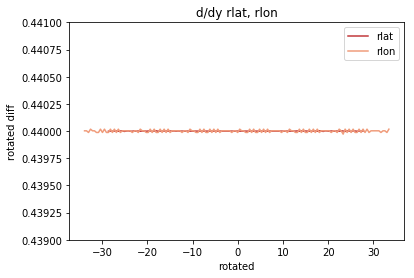

In [6]:
rlat, rlon = interp_dict['rlat'], interp_dict['rlon']
drlat, drlon = np.diff(rlat), np.diff(rlon)

plt.plot(rlat[:-1], drlat, label='rlat')
plt.plot(rlon[:-1], drlon, label='rlon')
plt.ylim(np.mean(drlat)-0.001, np.mean(drlat)+0.001)
plt.title("d/dy rlat, rlon")
plt.legend()
plt.xlabel("rotated")
plt.ylabel("rotated diff")
plt.savefig('grid_size_diff_plot')

## KDE Distributions from RCMs

Text(0.5, 1.0, 'KDE Distribution of Rain-RL50 Values')

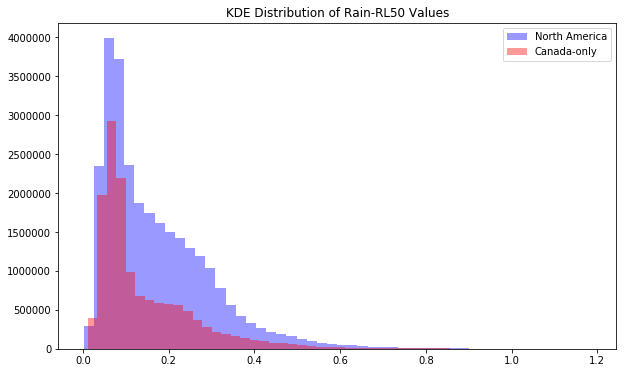

In [7]:
plt.figure(figsize=(10, 6))
sns.distplot(interp_dict['iens'][:, midx].flatten(), 
             color='blue', 
             kde = False, 
             label='North America')
sns.distplot(interp_dict['iens'][:, midx_shp].flatten(), 
             color='red', 
             kde = False, 
             label='Canada-only')
plt.legend()
plt.title('KDE Distribution of {} Values'.format(dv))

## Perform singular value decomposition and take first 4 EOFs

In [27]:
n = 4
u, s, vT = np.linalg.svd(iens.T, full_matrices=False)

explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]

# Remove unused/unecessary large variables
del u, s
vT.shape
n = np.where(np.cumsum(explained_variance_ratio) < 0.95)[0].shape[0]
vT = vT[:n, :]

<Figure size 432x288 with 0 Axes>

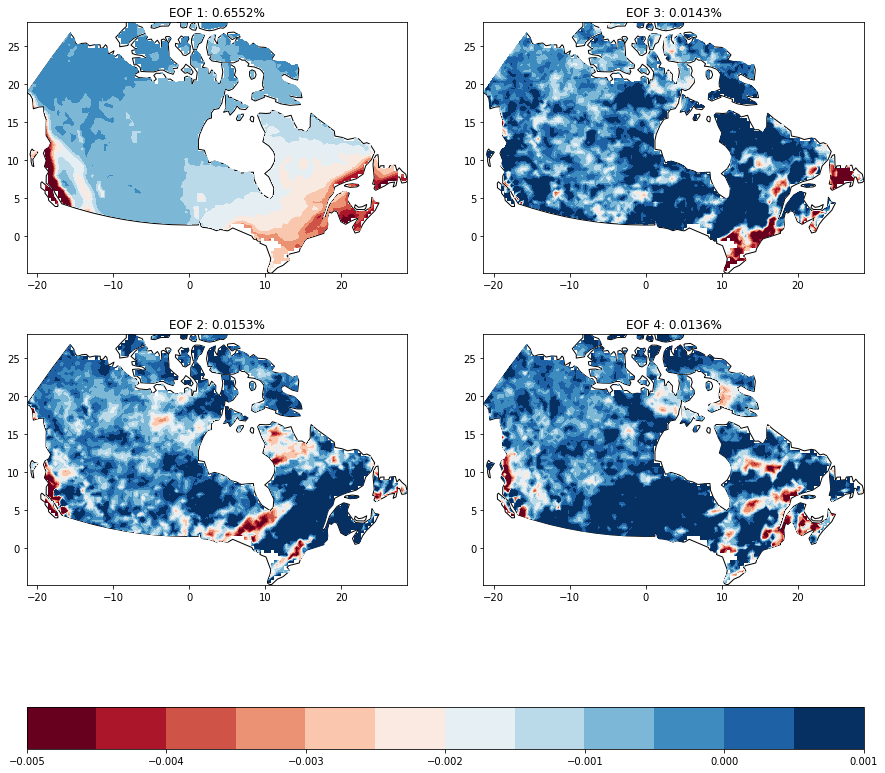

In [28]:
x1, x2, y1, y2 = interp_dict['irlon_ens'].min(), interp_dict['irlon_ens'].max(), interp_dict['irlat_ens'].min(), interp_dict['irlat_ens'].max()

iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
iens_copy[:n, midx_shp] = vT
X = np.reshape(iens_copy, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))

vmin, vmax = -0.005, 0.001

plt.tight_layout(pad=6.5)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
x, y = interp_dict['irlon'], interp_dict['irlat']

eof1 = ax[0, 0].imshow(X[0, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), zorder=2, label='EOF', vmin=vmin, vmax=vmax, extent=[x1, x2, y1, y2])
ax[0, 0].set_title('EOF 1: {0:.4f}%'.format(explained_variance_ratio[0]))
canada.plot(ax=ax[0, 0], color='white', edgecolor='black', zorder=1)
ax[0, 0].set_ylim(canada.bounds.miny.values[0], y2)
ax[0, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])


ax[1, 0].imshow(X[1, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), zorder=2, label='EOF', vmin=vmin, vmax=vmax, extent=[x1, x2, y1, y2])
ax[1, 0].set_title('EOF 2: {0:.4f}%'.format(explained_variance_ratio[1]))
canada.plot(ax=ax[1, 0], color='white', edgecolor='black', zorder=1)
ax[1, 0].set_ylim(canada.bounds.miny.values[0], y2)
ax[1, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])


ax[0, 1].imshow(X[2, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), zorder=2, label='EOF', vmin=vmin, vmax=vmax, extent=[x1, x2, y1, y2])
ax[0, 1].set_title('EOF 3: {0:.4f}%'.format(explained_variance_ratio[2]))
canada.plot(ax=ax[0, 1], color='white', edgecolor='black', zorder=1)
ax[0, 1].set_ylim(canada.bounds.miny.values[0], y2)
ax[0, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])


ax[1, 1].imshow(X[3, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), zorder=2, label='EOF', vmin=vmin, vmax=vmax, extent=[x1, x2, y1, y2])
ax[1, 1].set_title('EOF 4: {0:.4f}%'.format(explained_variance_ratio[3]))
canada.plot(ax=ax[1, 1], color='white', edgecolor='black', zorder=1)
ax[1, 1].set_ylim(canada.bounds.miny.values[0], y2)
ax[1, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])

plt.colorbar(eof1, ax=ax.ravel().tolist(), orientation='horizontal')
# plt.set_xlim(x.min(), x.max())

## Load the station data

In [29]:
df = pd.read_csv('/storage/home/nannau/Interim_snow_rain_load_LRstations_delivered_hist.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565


## Match observation station locations to their nearest interpolated CanRCM grid cell

In [92]:
dv = 'RL50 (kPa)'
ndf = match_coords(df, interp_dict, dv, midx_shp)
ndf = ndf[ndf['RL50 (kPa)'] > 0.0]
print("There are ", ndf.shape, "real station observations to fit.")

There are  (1, 5) real station observations to fit.


In [64]:
ndf_euclid = ndf['matched_idx']

In [88]:
ndf_haversine_copy = ndf_haversine*6391 
ndf_euclid_copy = ndf_euclid*0.0174532925199*6391

In [91]:
(np.max(np.abs(ndf_haversine_copy.values-ndf_euclid_copy.values)))*1000

821.0338496831433

In [85]:
np.mean(ndf_haversine_copy)

7.310197588932268

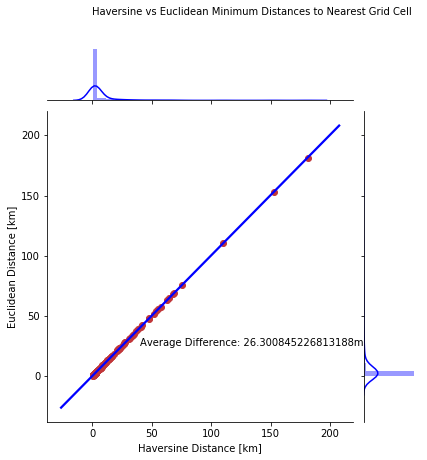

In [84]:
sns.jointplot(ndf_haversine_copy, ndf_euclid_copy, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
plt.scatter(ndf_haversine_copy, ndf_euclid_copy)
plt.xlabel('Haversine Distance [km]')
plt.ylabel('Euclidean Distance [km]')
plt.text(0, 300, 'Haversine vs Euclidean Minimum Distances to Nearest Grid Cell')
plt.text(40, 25, 'Average Difference: {}m'.format(np.abs(np.mean(ndf_haversine_copy.values-ndf_euclid_copy.values))*1000))
plt.savefig('euclid_vs_haversine')

## Create the pseudo observations and regress

In [12]:
obs_idx = generate_pseudo_obs(iens.T, 0.0003)
print("Taking", obs_idx[0].shape, "pseudo observations")

Taking (119,) pseudo observations


In [13]:
import pyproj
print(pyproj.__version__)

1.9.6


In [14]:
obs = iens.T[obs_idx]
eofs = vT[:n, obs_idx[1]]
# eofsold = vTold[:, obs_idx[1]]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (28, 119) 
Matched Obs shape:  (119,)


Fit the EOFs tot he pseudo observations and predict their values

In [15]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

print("Regressed model R^2 score: {}".format(model.score(eofs.T, predictions)))

Regressed model R^2 score: 1.0


slope 0.9862863382392669 r2_val 0.9931194984689744


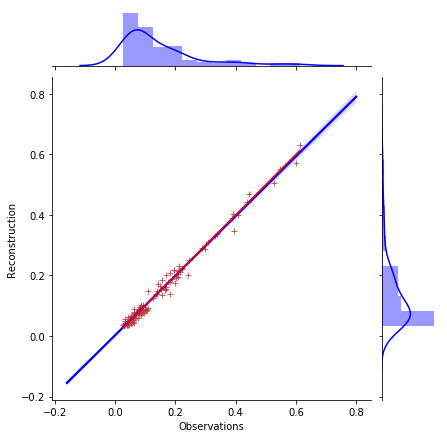

In [16]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

## Now use the real observations and regress

In [32]:
robs_idx = ndf['matched_idx']
robs = ((ndf[dv].values))
vT.shape, robs_idx.shape
reofs = vT[:n, robs_idx].T
reofs.shape, robs.shape, #obs.shape

((367, 28), (367,))

slope 1.0889276715640803 r2_val 0.8550285867810525


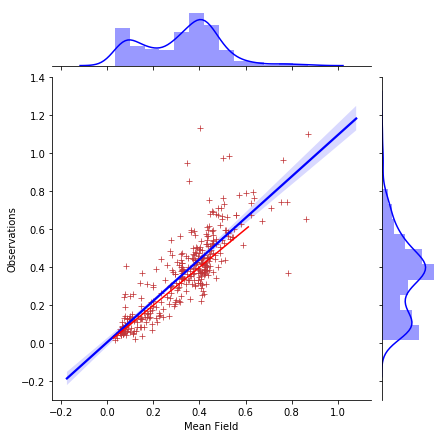

In [33]:
meanfield = iens.mean(axis=1)[robs_idx, ...]
sns.jointplot(meanfield, robs, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(meanfield, robs, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.ylabel('Observations')
plt.xlabel('Mean Field')

slope, intercept, r_value, p_value, std_err = linregress(meanfield, robs)
print("slope", slope, "r2_val", r_value)

Text(0, 0.5, 'Slope/R$^2$ Score')

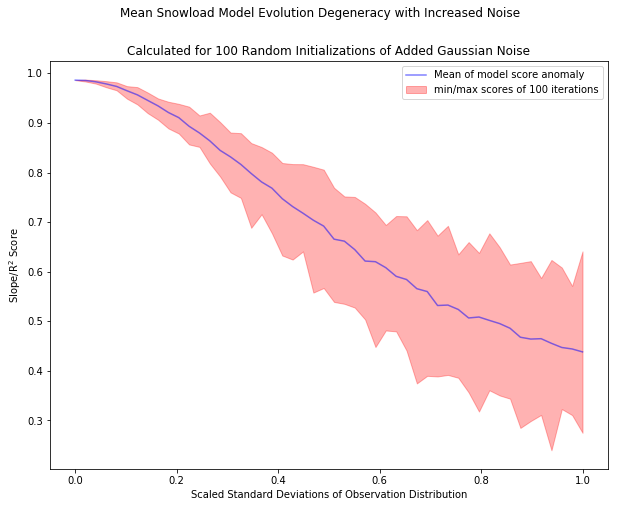

In [34]:
ys = []
x = eofs.T

ys1 = []
for i in range(0, 100):
    yslopes = []
    for sd in np.linspace(0, np.std(robs)):
        y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
        model = fit_eof(x, y)
        predictions = predict_dv(model, x)
        slope, intercept, r_value, p_value, std_err = linregress(y, predictions)

        yslopes.append(slope)
    ys.append(yslopes)

ys = np.array(ys)
fig, ax = plt.subplots(figsize=(10, 7.5))


plt.plot(np.linspace(0, np.std(robs))/np.std(robs), ys.mean(axis=0), color='blue', alpha=0.5,linestyle='-', label='Mean of model score anomaly')
ax.fill_between(np.linspace(0, np.std(robs))/np.std(robs), ys.min(axis=0), ys.max(axis=0), alpha = 0.3, color='red', label='min/max scores of 100 iterations')
plt.legend()
plt.suptitle('Mean Snowload Model Evolution Degeneracy with Increased Noise')
plt.title('Calculated for 100 Random Initializations of Added Gaussian Noise')
plt.xlabel('Scaled Standard Deviations of Observation Distribution')
plt.ylabel('Slope/R$^2$ Score')

Compare the distributions of the station observations and of the models

Fit the model and predict it

In [35]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()

df_results = pd.DataFrame({'Observations': robs, 'Reconstruction': linrpredictions, 'lat': ndf['lat']})
"Regressed model score from EOFs: {}".format(rmodel.score(reofs, robs))

'Regressed model score from EOFs: 0.7890299776240508'

slope of best fit 0.7890299776240516
r2 score of EOF fit 0.7890299776240508
r2_val of reconstruction score 0.8882735939022679
Std deviation ratio of vectors [models/]: 0.0738042861676272


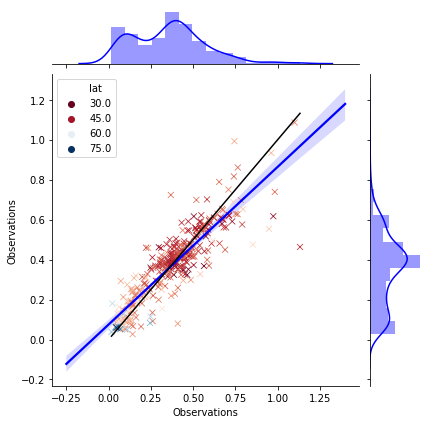

In [36]:
sns.jointplot('Observations', 'Reconstruction', color='blue',
marker='+', data=df_results,
kind="reg", scatter_kws={"s": 0.001})

sns.scatterplot('Observations', 'Reconstruction', marker='x', hue='lat', palette='RdBu', data=df_results)
sns.lineplot('Observations', 'Observations', data=df_results, color='black')
slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope of best fit", slope)
print("r2 score of EOF fit", rmodel.score(reofs, robs))
print("r2_val of reconstruction score", r_value)
print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

## Now reconstruct the spatial field

In [37]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[midx_shp] = rmodel.predict(vT[:n, :].T)
dv_recon[~midx_shp] = np.nan 

In [38]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

In [39]:
coordens = to_rotated(ndf['lat'].values, ndf['lon'].values)
ndf['rlat'], ndf['rlon'] = coordens['rlat_obs'], coordens['rlon_obs']

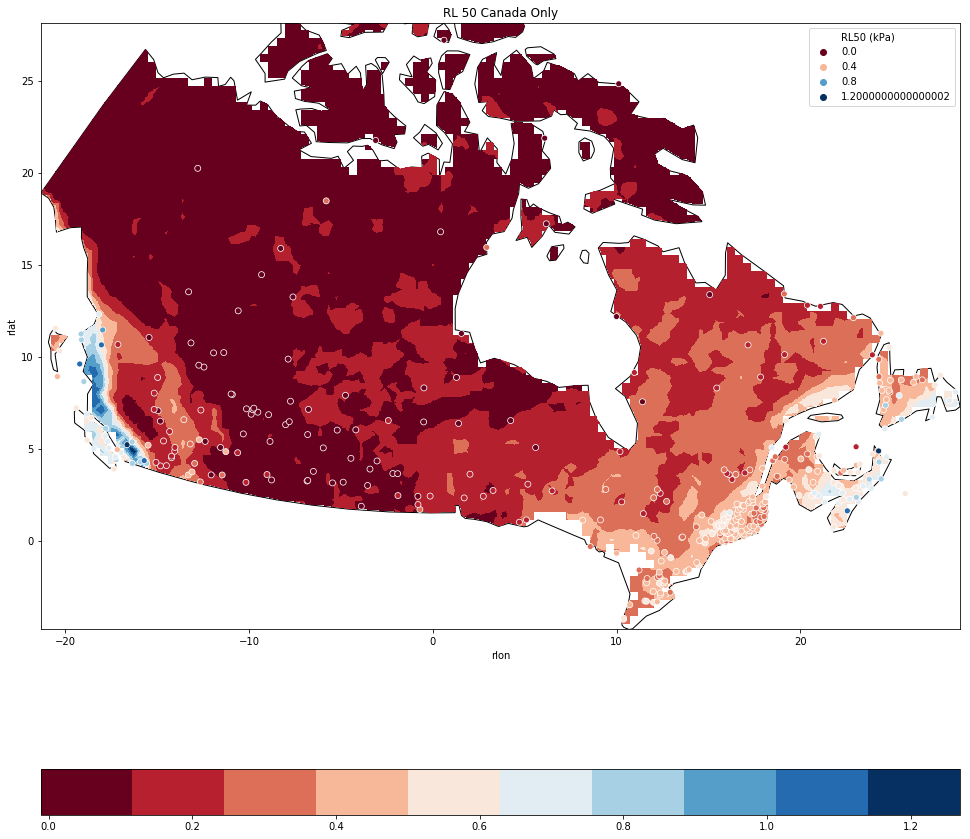

In [40]:
x1, x2, y1, y2 = interp_dict['irlon_ens'].min(), interp_dict['irlon_ens'].max(), interp_dict['irlat_ens'].min(), interp_dict['irlat_ens'].max()
f, ax = plt.subplots(1, figsize=(15, 15))
plt.tight_layout(pad=6.5)
canada.plot(ax=ax, color='white', edgecolor='black', zorder=1)
plt.imshow(dv_recon_sq, cmap=plt.cm.get_cmap('RdBu', 10), origin='lower', zorder=2, extent=[x1, x2, y1, y2])
sns.scatterplot(ndf.rlon, ndf.rlat, hue=ndf['RL50 (kPa)'], palette=plt.cm.get_cmap('RdBu', 10), zorder=3)
plt.ylim(canada.bounds.miny.values[0], y2)
plt.xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])

plt.title('RL 50 Canada Only')
plt.savefig('../plots/projection')
plt.colorbar(orientation='horizontal')

## Add noise to the ideal pseudo observations, regress, and reconstruct and compare each step with anomaly

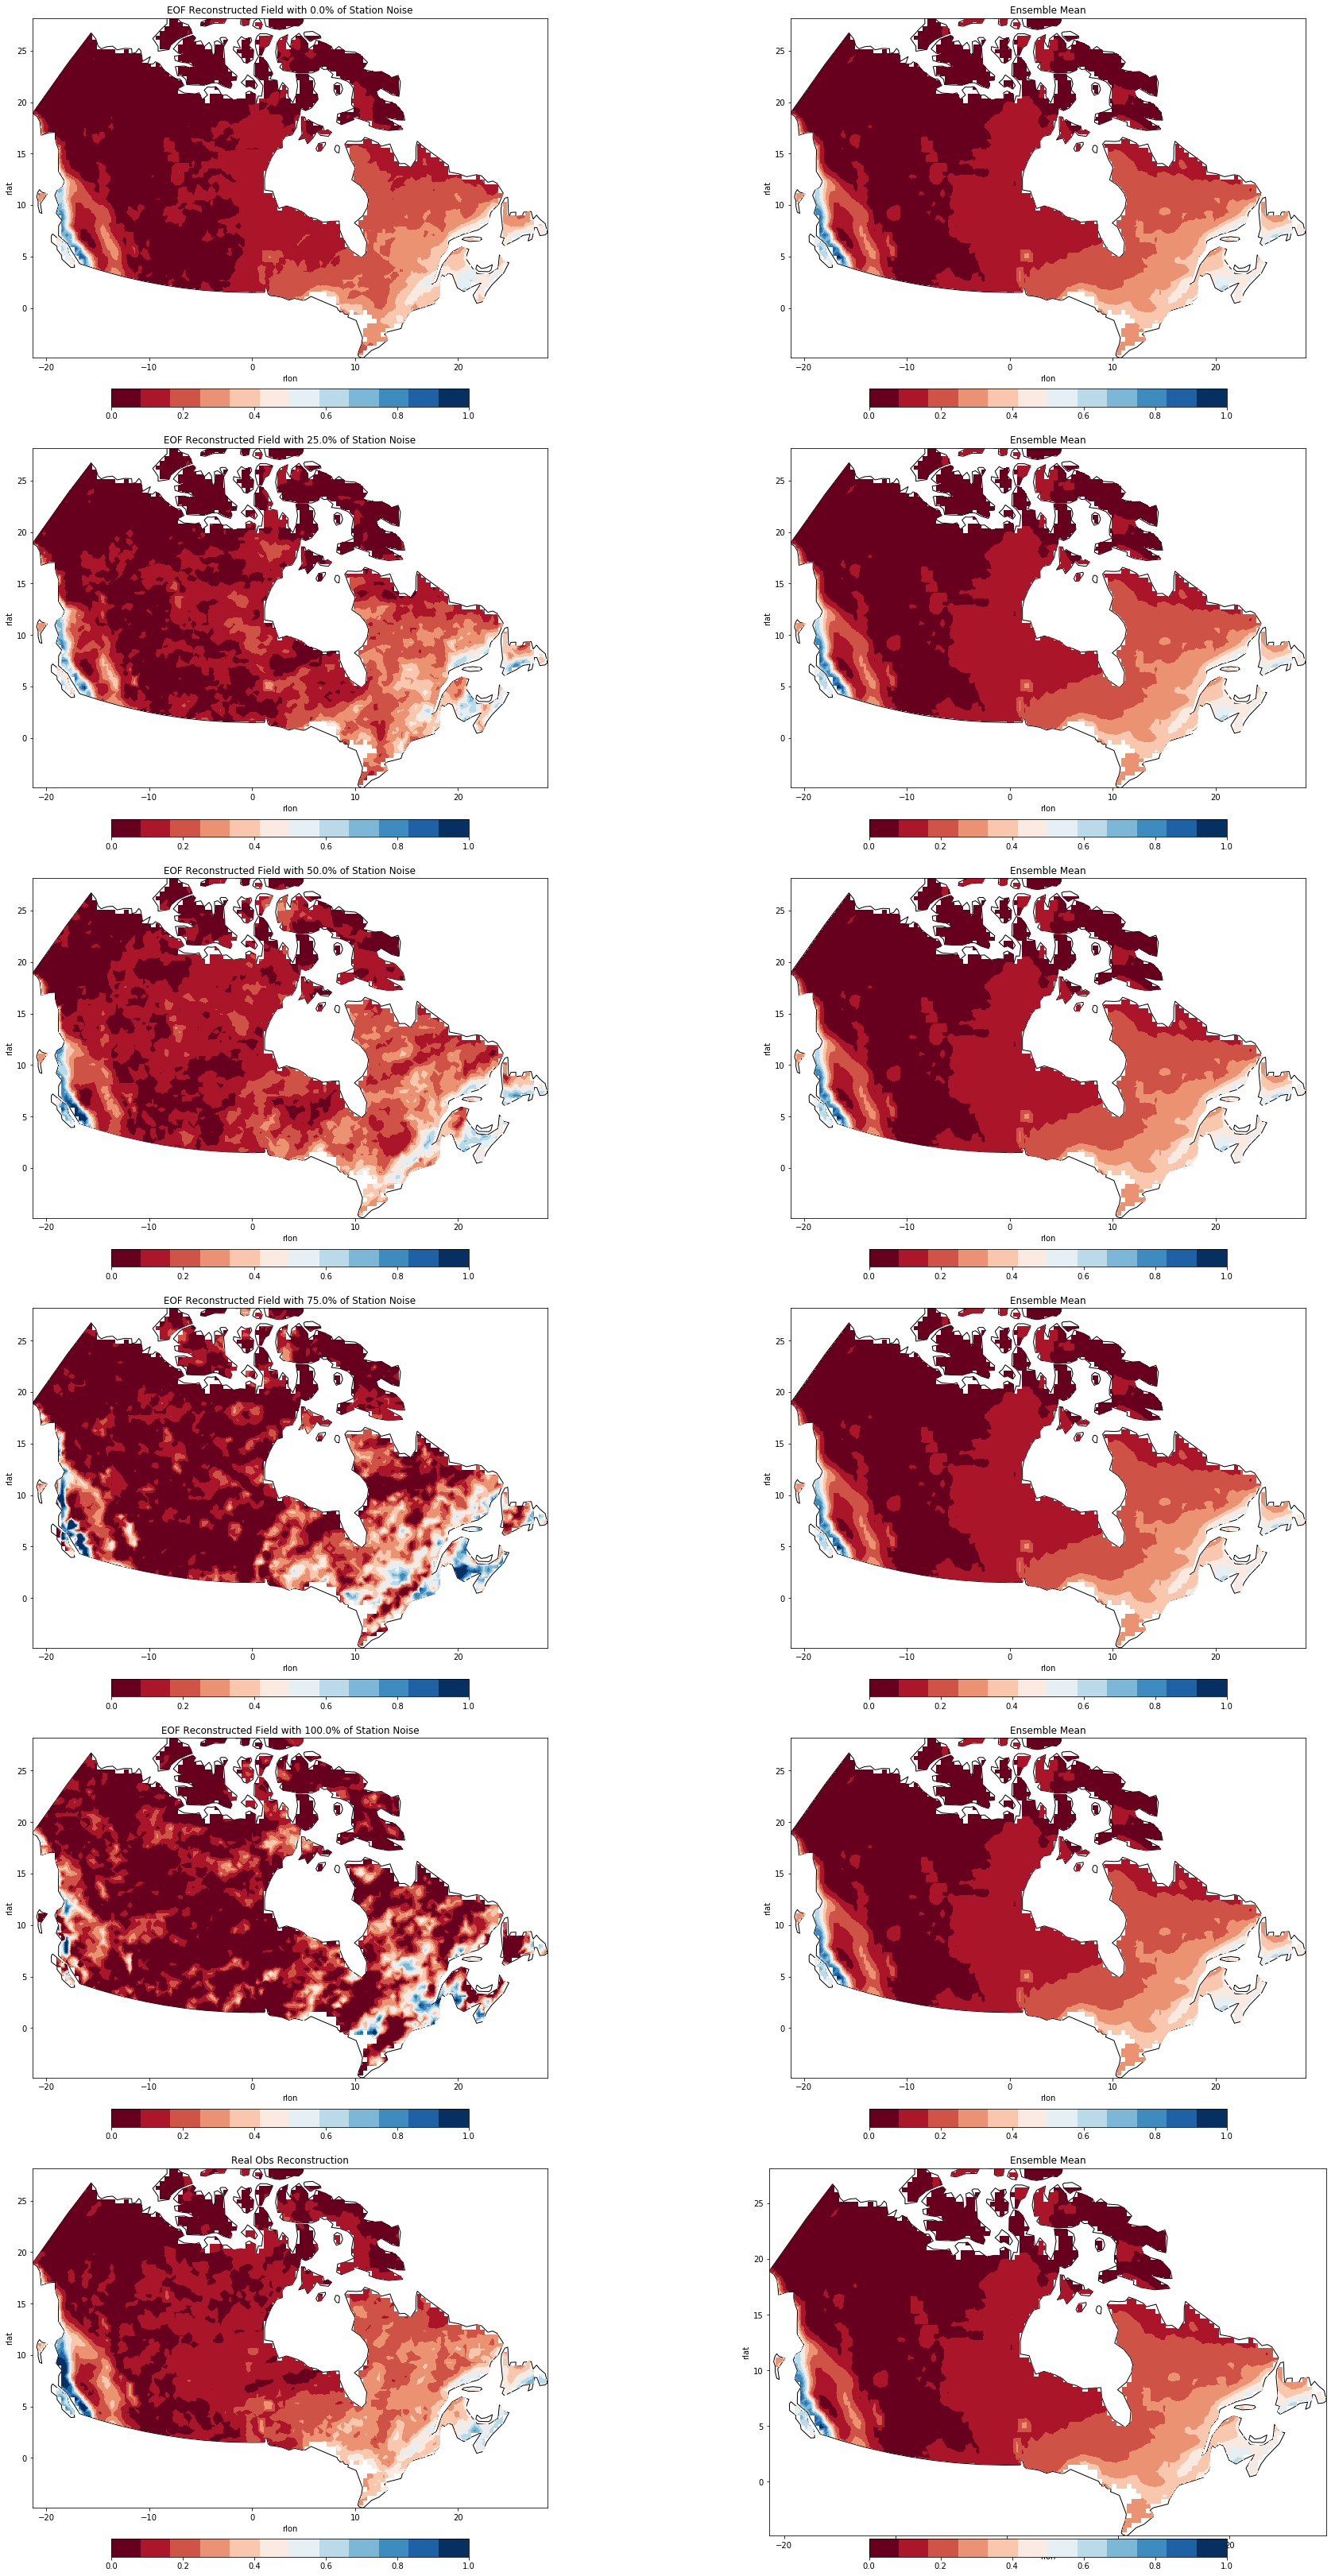

In [41]:
# del iens_copy, X, predictions, y, X_v
iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
X_v = interp_dict['iens']
X_v[:, ~midx_shp] = np.nan 
    
N=5
fig, ax = plt.subplots(N+1, 2, figsize=(30,45))
for i, sd in enumerate(np.linspace(0, np.std(robs), N)):
    y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
    model = fit_eof(eofs.T, y)

    predictions = predict_dv(model, vT.T)
    iens_copy[:, midx_shp] = predictions

    X = np.reshape(iens_copy, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    X_v = np.reshape(X_v, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    vmin, vmax = 0, 1
    xc, yc = interp_dict['irlon'], interp_dict['irlat']
    
    ax[i, 0].set_title('EOF Reconstructed Field with {}% of Station Noise'.format(100*sd/np.std(robs)))
    ax[i, 0].set_xlabel('rlon')
    ax[i, 0].set_ylabel('rlat')
    ax[i, 0].set_ylim(canada.bounds.miny.values[0], y2)
    ax[i, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[i, 0], color='white', edgecolor='black', zorder=1)

    img = ax[i, 0].imshow(X[0, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, zorder=2, extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 0], fraction=0.046, pad=0.08)

    ax[i, 1].set_title('Ensemble Mean')
    ax[i, 1].set_xlabel('rlon')
    ax[i, 1].set_ylabel('rlat')
    ax[i, 1].set_ylim(canada.bounds.miny.values[0], y2)
    ax[i, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    
    canada.plot(ax=ax[i, 1], color='white', edgecolor='black', zorder=1)

    img = ax[i, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, zorder=2, extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 1], fraction=0.046, pad=0.08)
    
    
ax[5, 0].set_title('Real Obs Reconstruction')
ax[5, 0].set_xlabel('rlon')
ax[5, 0].set_ylabel('rlat')    
img = ax[5, 0].imshow(dv_recon_sq, cmap=plt.cm.get_cmap('RdBu', 12), vmin=vmin, vmax=vmax,  zorder=2, origin='lower', extent=[xc.min(), xc.max(), yc.min(), yc.max()])
ax[5, 0].set_ylim(canada.bounds.miny.values[0], y2)
ax[5, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
canada.plot(ax=ax[5, 0], color='white', edgecolor='black', zorder=1)
plt.colorbar(img, orientation='horizontal', ax=ax[5, 0], fraction=0.046, pad=0.08)

ax[5, 1].set_title('Ensemble Mean')
ax[5, 1].set_xlabel('rlon')
ax[5, 1].set_ylabel('rlat')
img = ax[5, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12),  zorder=2, label='EOF', vmin=vmin, vmax=vmax, extent=[xc.min(), xc.max(), yc.min(), yc.max()])
ax[5, 1].set_ylim(canada.bounds.miny.values[0], y2)
ax[5, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
canada.plot(ax=ax[5, 1], color='white', edgecolor='black', zorder=1)
plt.colorbar(img, orientation='horizontal', ax=ax[5, 1], fraction=0.046, pad=0.008)

plt.tight_layout(pad=0.6, h_pad=1.9, w_pad=0.1)
plt.savefig('recon_mean_comparison_spatial.pdf')

del iens_copy, X, predictions, y, X_v